# Modules and MLPs

We've seen how the internals of simple linear classifier work. However, we still had to set a lot of things manually. It's much better to have a higher-level API that encapsulates the classifier.

We are going to see that now, with pytorch Module objects. Then, it will allow us to build more complex models, like a multilayer perceptron.

We begin by loading the data again:

In [1]:
import torch
import numpy as np
import mnist
from matplotlib import pyplot as pl

train_x = mnist.train_images()
train_y = mnist.train_labels()
test_x = mnist.test_images()
test_y = mnist.test_labels()

num_features = 28 * 28
num_classes = len(np.unique(train_y))
new_shape = [-1, num_features]
train_x_vectors = train_x.reshape(new_shape)
test_x_vectors = test_x.reshape(new_shape)

# shorten the names
train_x = train_x_vectors / 255
test_x = test_x_vectors / 255

#### Sequential

Let's create a model similar to the one in the previous notebook, but now with a more organized structure.

In [2]:
linear_layer = torch.nn.Linear(num_features, num_classes)
linear_model = torch.nn.Sequential(linear_layer)
loss_function = torch.nn.CrossEntropyLoss()

The model can be called as function to compute an output. Let's see how it works:

In [3]:
batch_size = 8
batch = torch.tensor(train_x[:batch_size], dtype=torch.float)
labels = torch.tensor(train_y[:batch_size], dtype=torch.long)

answers = linear_model(batch)
answers

tensor([[ 0.0956, -0.2754, -0.1535,  0.2865, -0.1412,  0.0471, -0.1065,  0.1094,
          0.1190, -0.2937],
        [ 0.1604, -0.1357, -0.0376,  0.0351,  0.0496,  0.2543, -0.1427,  0.0383,
         -0.0472,  0.1612],
        [ 0.0770, -0.3192, -0.2866,  0.0479,  0.0908, -0.2516, -0.0969,  0.0856,
          0.1332, -0.0350],
        [ 0.0981,  0.0571,  0.2533,  0.2395, -0.0491,  0.0306, -0.0311, -0.0367,
         -0.0059, -0.2250],
        [-0.1954, -0.0254, -0.1494, -0.0503, -0.1403,  0.0252,  0.1430,  0.0287,
          0.1665,  0.1855],
        [ 0.0893, -0.1601, -0.1125, -0.0534, -0.1407,  0.0726,  0.0176,  0.1534,
          0.3093,  0.3125],
        [-0.0615, -0.3229,  0.2567,  0.0470, -0.2827, -0.1588, -0.0260, -0.0509,
          0.0759, -0.1551],
        [ 0.3846, -0.0618, -0.2166,  0.1995,  0.0960,  0.2370, -0.0642,  0.2708,
          0.1216, -0.0027]], grad_fn=<ThAddmmBackward>)

#### Optimizer

The answers and loss are pretty much in the same way as in our last notebook. Now let's define an optimizer that will update weights more efficiently.

In [4]:
learning_rate = 1e-2

# the optimizer needs to be told which are the parameters to optimize
optimizer = torch.optim.SGD(linear_model.parameters(), lr=learning_rate)

#### Training loop

Now we write the main training loop. This is the basic skeleton for training pytorch models.

In [6]:
def train_model(model, train_x, train_y, num_epochs, batch_size, optimizer):
    losses = []

    for epoch in range(num_epochs):
        print('Starting epoch %d' % epoch)
        batch_index = 0
        total_loss = 0

        while batch_index < len(train_x):
            # get the data for this batch
            next_index = batch_index + batch_size
            batch_x = torch.tensor(train_x[batch_index:next_index], dtype=torch.float)
            batch_y = torch.tensor(train_y[batch_index:next_index], dtype=torch.long)
            batch_index = next_index

            # forward pass
            logits = model(batch_x)

            # compute the loss
            loss = loss_function(logits, batch_y)
            loss_value = loss.item()
            total_loss += loss_value
            losses.append(loss_value)

            # important: zero the gradients before recomputing them again
            model.zero_grad()
            loss.backward()

            # after determining the gradients, take a step toward their direction
            optimizer.step()

        avg_loss = total_loss / len(train_x)
        print('Epoch loss: %.4f' % avg_loss)
    
    return np.array(losses)

In [7]:
losses = train_model(linear_model, train_x, train_y, 5, 8, optimizer)

Starting epoch 0
Epoch loss: 0.0627
Starting epoch 1
Epoch loss: 0.0432
Starting epoch 2
Epoch loss: 0.0401
Starting epoch 3
Epoch loss: 0.0385
Starting epoch 4
Epoch loss: 0.0374


Knowing the loss decreases is good, but in classification problems, we usually want to know other metrics such as accuracy or F1.

**Exercise:** Include accuracy report!

Graphics are good to understand the performance of a model. Let's plot the loss curve by batch:

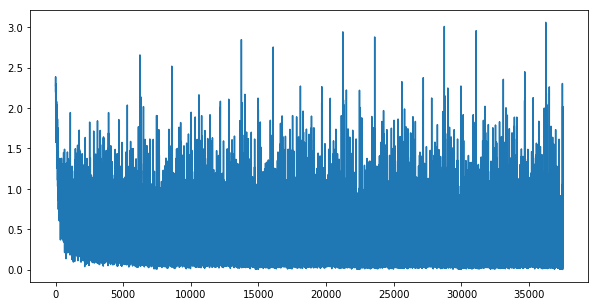

In [8]:
%matplotlib inline
pl.rcParams['figure.figsize'] = [10, 5]
pl.plot(losses)

That might be too dense, although we can see that the loss doesn't decrease smoothly. Let's downsample the array, picking only every 10th value, remove the lines and try again.

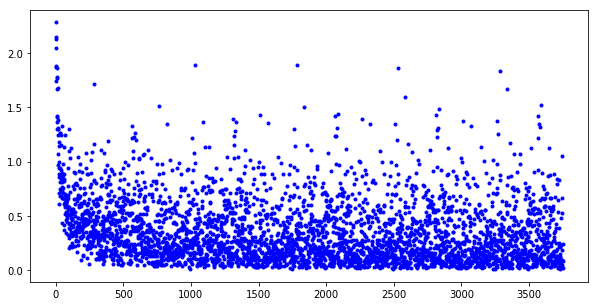

In [9]:
pl.plot(losses[::10], 'b.')

Now it is clearer to see that the bulk of the batches have a lower loss. Interestingly, some patterns of hard examples to classify are repeated every epoch.

## Multilayer Perceptron

We can now proceed to a more sofisticated classifier: a multilayer perceptron. Let's build one using the Sequential API.

In [10]:
hidden_size = 200
learning_rate = 1e-2

linear_layer1 = torch.nn.Linear(num_features, hidden_size)
linear_layer2 = torch.nn.Linear(hidden_size, num_classes)
mlp = torch.nn.Sequential(linear_layer1, 
                          torch.nn.ReLU(), 
                          linear_layer2)

optimizer = torch.optim.SGD(mlp.parameters(), lr=learning_rate)

Now let's train the model. How do the loss and accuracy compare with the linear model?

You probably also noticed a difference in running time!

In [11]:
losses = train_model(mlp, train_x, train_y, 3, 8, optimizer)

Starting epoch 0
Epoch loss: 0.0579
Starting epoch 1
Epoch loss: 0.0299
Starting epoch 2
Epoch loss: 0.0231


Notice the different concentration of dots in the MLP and Linear graphics!

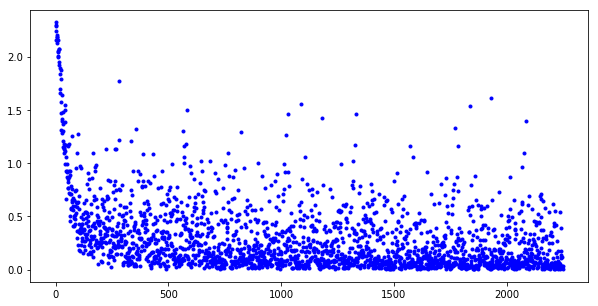

In [12]:
pl.plot(losses[::10], 'b.')

### Validation data

Evaluating the performance on training data is important to understand if the model is actually learning, but if we want to know if our model has any usefulness, we should evaluate its performance on validation or test data.



In [13]:
def evaluate_model(model, test_x, test_y):
    test_x = torch.tensor(test_x, dtype=torch.float)
    test_y = torch.tensor(test_y, dtype=torch.long)
    loss_function = torch.nn.CrossEntropyLoss()
    logits = model(test_x)
    loss = loss_function(logits, test_y)
    return loss

In [14]:
evaluate_model(mlp, test_x, test_y)

tensor(0.1681, grad_fn=<NllLossBackward>)

In [15]:
evaluate_model(linear_model, test_x, test_y)

tensor(0.2899, grad_fn=<NllLossBackward>)

Validation loss is way higher than training loss: that's plain overfitting.

How can we remedy that? There are two things to be done:

1. **Generalize better**. This include either finding some better feature representation or regularizing, i.e., add some kind of penalty to the model weights that encourages it to find a more general solution. Examples: L2-norm weight regularization, dropout.
1. **Early stop**. Evaluate the model on validation data after each epoch or some number of batches; only save it when validation performance increases. This means detecting when the model achieved its performance peak.

#### Dropout

We could try dropout. It effectivelly deactivates some neural connections at random, forcing the network to avoid depending on specific inputs.

In [16]:
hidden_size = 200
learning_rate = 1e-2

linear_layer1 = torch.nn.Linear(num_features, hidden_size)
linear_layer2 = torch.nn.Linear(hidden_size, num_classes)
mlp_dropout = torch.nn.Sequential(linear_layer1, 
                          torch.nn.ReLU(), 
                          torch.nn.Dropout(0.25),  # drop 25% of the connections
                          linear_layer2)

optimizer_dropout = torch.optim.SGD(mlp_dropout.parameters(), lr=learning_rate)

In [17]:
losses = train_model(mlp_dropout, train_x, train_y, 3, 8, optimizer_dropout)

Starting epoch 0
Epoch loss: 0.0625
Starting epoch 1
Epoch loss: 0.0319
Starting epoch 2
Epoch loss: 0.0249


Training loss is a bit worse, as expected. After all, we are obstructing some connections.

Now let's check validation performance:

In [18]:
evaluate_model(mlp_dropout, test_x, test_y)

tensor(0.1790, grad_fn=<NllLossBackward>)

No improvement. Ideally, we should retrain our model with different hyperparamters (learning rates, layer sizes, number of layers, dropout rate) as well as some changes in the structure (different optimizers, activation functions, losses).

However, data representation plays a key role. Do you think representing the input as independent pixels is a good idea for recognizing digits?

### Saving

Persisting the model after training is obviously important to reuse it later.

In Pytorch, we can save the model calling `save()` and passing  the model's `state_dict`.

In [19]:
torch.save(mlp.state_dict(), 'mlp.model')

Later, recreate the model and load the data.

In [27]:
mlp2 = torch.nn.Sequential(linear_layer1, 
                          torch.nn.ReLU(), 
                          linear_layer2)
mlp2.load_state_dict(torch.load('mlp.model'))

Let's check the performance to see if it's the same!

In [28]:
evaluate_model(mlp, test_x, test_y)

tensor(0.1681, grad_fn=<NllLossBackward>)

**Exercise:** implement early stopping, so the model is saved whenever it reaches a lower loss best.